Vamos a intentar reconstruir el período (`PeriodLS`) de una estrella RRLyrae usando procesos gaussianos.

# Código Auxiliar

## Imports
Pongo los imports acá porque no discutimos organización de código.

In [20]:
import carpyncho
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from period_reconstruction.light_curve import LightCurve
from catalog.catalog_loader import CatalogLoader
from sklearn.gaussian_process import GaussianProcessRegressor

## Funciones auxiliares

### Graficación

In [33]:
# Auxiliary plotting functions.

# Given a light curve, plots magnitude vs HJD.
def plot_chronological(lc: LightCurve):

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.errorbar(
        lc.time, lc.mag, lc.err, ls="", marker="o", color="tab:blue", ecolor="tab:red"
    )

    ax.set_title(f"Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("HJD")

    ax.invert_yaxis()
    fig.tight_layout()


# Given a periodic light curve, plots magnitude vs period in two phases.
def plot_periodic(lc: LightCurve):
    # duplicate the values in two phases
    phases = np.hstack((lc.phases, lc.phases + 1))
    pmag = np.hstack((lc.pmag, lc.pmag))
    perr = np.hstack((lc.perr, lc.perr))

    # plot the folded light curve
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(
        phases, pmag, perr, ls="", marker="o", ecolor="tab:blue", color="tab:red"
    )
    ax.set_title(f"Folded Light Curve")
    ax.set_ylabel("Magnitude")
    ax.set_xlabel("Phase")
    ax.invert_yaxis()

    fig.tight_layout()

    return ax

# Reconstrucción de Período

## Obtención de los datos
Primero descargamos el tile `b278` y filtramos las RRLyrae.

In [22]:
# Get the catalogs.
loader = CatalogLoader("../catalog")
b278_lc = loader.get_lc("b278")
b278_features = loader.get_features("b278")

# Filter RRLyraes from the catalogs.
periodic_star_types = ["RRLyr-RRab", "RRLyr-RRc", "RRLyr-RRd"]
b278_features = b278_features[b278_features["vs_type"].isin(periodic_star_types)]
b278_lc = b278_lc[b278_lc.bm_src_id.isin(b278_features.id.to_numpy())]

Elegimos la RRLyrae con máxima cantidad de observaciones y filtramos por SNR.

In [23]:
# Find a star with maximum amount of observations.
star = b278_features.loc[b278_features["cnt"].idxmax()]
# Get the observations for the star.
light_curve = b278_lc[b278_lc.bm_src_id == star.id]

lc = LightCurve(light_curve, star.PeriodLS, GaussianProcessRegressor())
lc.filter_snr(20)
len(lc.time)

220

Graficamos la magnitud respecto de la fecha de la observación.

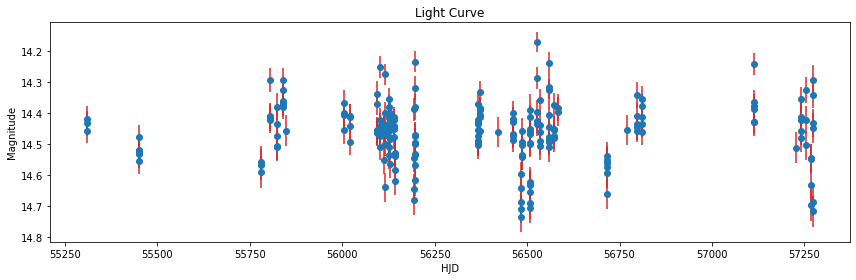

In [24]:
plot_chronological(lc)

Graficamos la magnitud respecto del período que indica `PeriodLS` en el catálogo.

<AxesSubplot:title={'center':'Folded Light Curve'}, xlabel='Phase', ylabel='Magnitude'>

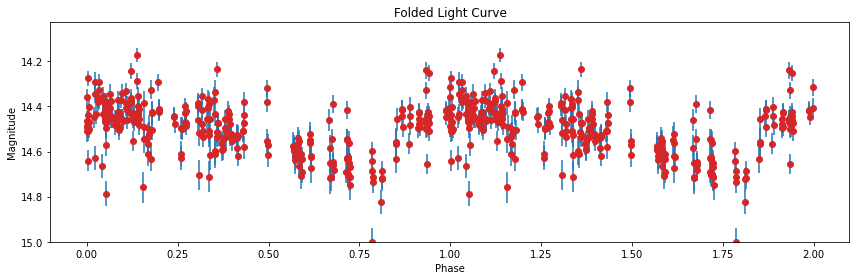

In [34]:
ax = plot_periodic(lc)
ax.set_ylim(bottom=15)
ax

🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔🤔

## Reconstrucción del período
Ahora el experimento. Vamos a elegir `n_sample` puntos de la curva de luz al azar y vamos a poner esos puntos en fase usando Lomb-Scargle. Luego vamos a hacer `n_iter` veces lo siguiente:
* Entrenar un proceso gaussiano con los puntos.
* Utilizarlo para agregar `n_synthetic` puntos que se encuentran en un valor al azar (uniformemente distribuido) de la fase.
* Utilizar todos los puntos para recalcular el período usando Lomb-Scargle.
  
Queremos ver si logramos acercarnos al período del catálogo.

In [26]:
# Parameters.
n_sample = 80
n_iter = 40
n_synthetic = 1

In [27]:
period_list = []
period_fit_list = []

sample = light_curve.sample(n=n_sample)
synthetic_lc = LightCurve(sample, star.PeriodLS, GaussianProcessRegressor())

for _ in range(n_iter):
    synthetic_lc.add_synthetic(n_synthetic)
    period, period_fit = synthetic_lc.make_periodic()
    period_list.append(period)
    period_fit_list.append(period_fit)

## Resultados

A ver el período que calculó en cada paso...

In [28]:
period_list

[0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.14703580564838029,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558,
 0.9972390208899558]

Da horrible... Se clava en 0.5 o en 1.

In [29]:
period_fit_list

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

Y si graficamos los puntos queda algo nada que ver (obvio, porque el período no tiene nada que ver con el original).

0.9972390208899558

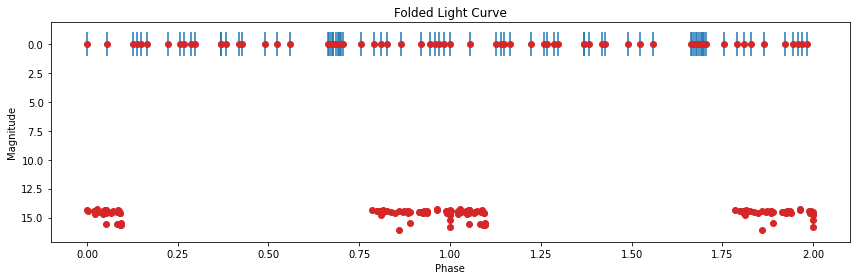

In [30]:
plot_periodic(synthetic_lc)
synthetic_lc.period